In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AnnotationsPos_0.000000_crop001121b_0.png to AnnotationsPos_0.000000_crop001121b_0.png


In [ ]:
import os
import cv2
import numpy as np
from bisect import bisect_left

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
!ls

drive  sample_data


##HOG

In [ ]:
def get_histogram_values_and_positions( angle, magnitud):

  bin_of_angles = [0, 20, 40, 60, 80, 100, 120, 140, 160]

  if angle > 180:
    angle = angle-180

  bin_position = bisect_left(bin_of_angles, angle+1)
  bin_position = bin_position - 1 # -1 porque el index empieza en 0

  # ==Ejemplo==
  # angulo = 36
  # bin_position = 2 -> esta en la posicion 2 de los rangos del bin
  # start_angle = 20
  # end_angle = 40


  start_angle = bin_of_angles[bin_position] 
  end_angle = start_angle + 20

  

  substr_bin_1 = end_angle - angle
  substr_bin_2 = angle - start_angle
  

  bin_magnitud = ( substr_bin_1 / 20 ) * magnitud
  bin_magnitud_2 = ( substr_bin_2 / 20 ) * magnitud



  bin_position_2 = bin_position + 1

  if bin_position == 9:
    bin_position_2 = 0 #da la vuelta al array para tomar el bin inicial

  return bin_magnitud, bin_magnitud_2, bin_position , bin_position_2




In [ ]:
def create_patch_histogram(patch, mag_patch, ang_patch):

  patch_histogram = np.zeros(9, dtype='float32')

  for x in range(0, 8): #filas
    for y in range(0, 8): #columnas

      current_mag = mag_patch[x, y]
      current_angle = ang_patch[x, y]

      mag_1, mag_2, pos_1, pos_2 = get_histogram_values_and_positions(current_mag, current_angle)

      patch_histogram[pos_1] = patch_histogram[pos_1] + mag_1
      patch_histogram[pos_2] = patch_histogram[pos_2] + mag_2


  return patch_histogram

In [ ]:
def create_histograms_per_patch(img, magnitudes, angles):

  histograms = np.zeros((16, 8, 9), dtype='float32') #almacenaremos los histogramas (length 9) en una matriz de 16x8 por los patches de 8x8
  fila = -1
  columna = -1

  for x in range(0, img.shape[0], 8): #recorre las filas

    histogram_patch = []
    columna = -1

    for y in range (0, img.shape[1], 8): #recorre las columnas

      patch = img[x:x+8, y:y+8]
      mag_patch = magnitudes[x:x+8, y:y+8]
      ang_patch = angles[x:x+8, y:y+8]

      histogram_patch = create_patch_histogram(patch, mag_patch, ang_patch)
      columna += 1

    fila += 1

    histograms[fila, columna] = histogram_patch
  
  return histograms

In [ ]:
def normalise_histograms(whole_img_histograms):

  normalised_histograms = np.zeros((15, 7, 36), dtype='float32') #almacenaremos los histogramas normalizados (length 36)
  fila = -1
  columna = -1                                                # en una matriz de 15x7

  for x in range(0, 15): #filas

    normalised_vector= []
    columna = -1

    for y in range(0, 7): #columnas

      hist_patch = whole_img_histograms[x: x+2, y: y+2] #tomamos los histogramas en en cuadrados de 2X2 para normalizar
      hist_flatten = hist_patch.flatten() # para crear un array de 36x1
      k_value = np.sqrt(np.sum(np.square(hist_flatten), axis=0))
      
      if k_value == 0:
        normalised_vector = hist_flatten
      else:
        normalised_vector = hist_flatten / k_value


      columna += 1

    fila += 1

    normalised_histograms[fila, columna] = normalised_vector

  return normalised_histograms


In [ ]:
def get_hog_features(img):

  # Calcular gradient
  gradientX = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
  gradientY = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)

  # Python Calcula el gradient magnitud y  direccion ( in grados )
  magnitudes, angles = cv2.cartToPolar(gradientX, gradientY, angleInDegrees=True)

  whole_img_histograms = create_histograms_per_patch(img, magnitudes, angles)

  whole_normalised_hist = normalise_histograms(whole_img_histograms)

  final_features = whole_normalised_hist.flatten() # 378
  
  return final_features

## Hog model train



In [ ]:
images = []
labels = []

image_folders = ['Background', 'Pedestrians']
#image_paths = ['./Pedestrians-Dataset/']
main_folder = './drive/MyDrive/train_dataset'

In [ ]:
for sub_folder in image_folders:
    
  # obtener el nombre de todas la imagenes
  all_images = os.listdir(f"{main_folder}/{sub_folder}")
  
  # recorrer todas las imagenes
  for image in all_images:
    image_path = f"./{main_folder}/{sub_folder}/{image}"

    # Leer imagen
    img = cv2.imread(image_path,0)
    #img = cv2.resize(img, (64, 128))
    img = np.float32(img) / 255.0


    hog_desc = np.zeros(378, dtype='float32')
    hog_desc = get_hog_features(img)
    

    # update the data and labels
    images.append(hog_desc)
    labels.append(sub_folder)

In [ ]:
print('Entrenando en imagenes...')
svm_model = LinearSVC(random_state=42, tol=1e-5)
svm_model.fit(images, labels)
print('Entrenamiento finalizado ;)')

Entrenando en imagenes...
Entrenamiento finalizado ;)


In [ ]:
pred = svm_model.predict(hog_test.reshape(1, -1))[0]
pred

'Pedestrians'

In [ ]:
import pickle

In [ ]:
filename = 'svm_trained_model3.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [ ]:
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Test del modelo

In [ ]:
# load the model from disk
import pickle

filename = './svm_trained_model.sav'
svm_model = pickle.load(open(filename, 'rb'))

In [ ]:
from skimage import feature

Test del modelo con valores de HOG generados por libreria

In [ ]:
# get the HOG descriptor for the image
pedestrian = cv2.imread('test_pedestrian.png', cv2.IMREAD_COLOR)
pedestrian = cv2.cvtColor(pedestrian, cv2.COLOR_BGR2GRAY)
pedestrian = np.float32(pedestrian) / 255.0

#hog_desc = feature.hog(pedestrian, orientations=9, pixels_per_cell=(8, 8),
#                       cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')

background = cv2.imread('test_background.png', cv2.IMREAD_COLOR)
background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
background = np.float32(background) / 255.0

In [ ]:
hog_test_b = get_hog_features(background)
pred = svm_model.predict(hog_test_b.reshape(1, -1))[0]
pred

'Background'

In [ ]:
hog_test_p = get_hog_features(pedestrian)
pred = svm_model.predict(hog_test_p.reshape(1, -1))[0]
pred

'Pedestrians'

## Procesamiento de la imagen inicial con Pyramids & Sliding Window

In [ ]:
import imutils

In [ ]:
def img_pyramids(image, scale=1.5, minSize=(64, 128)):
  # yield la imagen original
  yield image

  # loop para el resize
  while True:
    #rescale
    w = int(image.shape[1] / scale) #width 
    image = imutils.resize(image, width=w)

    # si la imagen no tiene el tamaño minimo detiene el loop
    if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
      break
    
    yield image

In [ ]:
def sliding_window(image, stepSize, windowSize):
  
  for y in range(0, image.shape[0], stepSize):
    for x in range(0, image.shape[1], stepSize):

      # retorna la window actual
      yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [ ]:
def detect_pedestrians(image, winW, winH):

  pyramid_count = 0
  resize_info = []

  minSizeY = image.shape[0] * 0.2
  minSizeX = image.shape[1] * 0.2

  # Obtenemos cada piramide de la imagen inicial
  for resizedImg in img_pyramids(image, scale=1.5, minSize=[minSizeX, minSizeY]):

    pyramid_count += 1

    # aplicamos la sliding window a cada layer de la piramide
    for (x, y, window) in sliding_window(resizedImg, stepSize=128, windowSize=[winW, winH]):

      # Si la window restante es de tamaño diferente a la que queremos , salta a la siguiente piramide.
      # Esto pasa porque a veces ya recorrimos la mayor parte de la piramide y solo quedan unos cuantos pixeles
      # faltantes por lo tanto no se ajusta al tamaño y/o aspect-ratio de la window
      if window.shape[0] != winH or window.shape[1] != winW:
        continue
      

      # CLASSIFIER
      img = cv2.cvtColor(window, cv2.COLOR_RGB2GRAY)
      img = cv2.resize(img, (64, 128))
      img = np.float32(img) / 255.0

      hog = np.zeros(378, dtype='float32')
      hog = get_hog_features(img)

      prediction = svm_model.predict(hog.reshape(1, -1))[0]

      if prediction == 'Pedestrians':
        resize_info.append({'pts': (x, y), 'pyramid_n' : pyramid_count})


  return resize_info
    

In [ ]:
def draw_rectangles(image, resize_info, windowW, windowH):

  colors = [(0, 255, 0), (38, 235, 208), (69, 72, 230), (163, 235, 40)] 
  indx = 0
  clone = image.copy()

  for info in resize_info:

    #coordenada en X-Y * piramide numero N
    start_point = info['pts'][0] * info['pyramid_n'] , info['pts'][1] * info['pyramid_n'] 
    windowW = windowW * info['pyramid_n']
    windowH = windowH * info['pyramid_n']

    end_point = start_point[0] + windowW, start_point[1] + windowH
    color = (0, 255, 0)#green

    cv2.rectangle(clone, start_point, end_point, colors[indx] , 4)

    indx += 1
    if indx >= len(colors) :
      indx = 0
    
    
  return clone

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#====TEST CON VARIAS IMAGENES======
#image = cv2.imread('./paris-courir-quais.jpg')
image = cv2.imread('./140508.jpg')
#image = cv2.imread('./test_pedestrian2.jpg')


image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


winW = 200 #windowSize
winH = winW * 2 #aspect-ratio de 1:2


resize_info = detect_pedestrians(image, winW, winH)

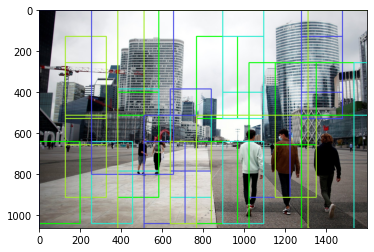

In [ ]:
plt.imshow(draw_rectangles(image, resize_info, winW, winH))

Guardar imagen

In [ ]:
cv2.imwrite('./test_result.jpg', image)

True